In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('whitegrid')
cp = sns.color_palette()

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Input variables:
#### bank client data:

   1. age (numeric)
   2. job : type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")
   3. marital : marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)
   4. education (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")
   5. default: has credit in default? (categorical: "no","yes","unknown")
   6. housing: has housing loan? (categorical: "no","yes","unknown")
   7. loan: has personal loan? (categorical: "no","yes","unknown")
   
#### related with the last contact of the current campaign:

   8. contact: contact communication type (categorical: "cellular","telephone") 
   9. month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
   10. day_of_week: last contact day of the week (categorical: "mon","tue","wed","thu","fri")
   11. duration: last contact duration, in seconds (numeric). Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
  
#### other attributes:
  
   12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
   13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
   14. previous: number of contacts performed before this campaign and for this client (numeric)
   15. poutcome: outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")
  
#### social and economic context attributes
   
   16. emp.var.rate: employment variation rate - quarterly indicator (numeric)
   17. cons.price.idx: consumer price index - monthly indicator (numeric)     
   18. cons.conf.idx: consumer confidence index - monthly indicator (numeric)     
   19. euribor3m: euribor 3 month rate - daily indicator (numeric)
   20. nr.employed: number of employees - quarterly indicator (numeric)

### Output variable (desired target):
  
   21. y - has the client subscribed a term deposit? (binary: "yes","no")


### Missing Attribute Values: 
There are several missing values in some categorical attributes, all coded with the "unknown" label. These missing values can be treated as a possible class label or using deletion or imputation techniques. 


<hr>
# Loading the data


In [3]:
data = pd.read_csv('data/bank-additional-full.csv', sep=';')
data.columns = data.columns.str.replace('.', '_')
data['y_numeric'] = data['y'].map({'no': 0, 'yes': 1})

In [5]:
data.shape

(41188, 22)

In [6]:
data.head().T

,0,1,2,3,4
age,56,57,37,40,56
job,housemaid,services,services,admin.,services
marital,married,married,married,married,married
education,basic.4y,high.school,high.school,basic.6y,high.school
default,no,unknown,no,no,no
housing,no,no,yes,no,no
loan,no,no,no,no,yes
contact,telephone,telephone,telephone,telephone,telephone
month,may,may,may,may,may
day_of_week,mon,mon,mon,mon,mon


# Target

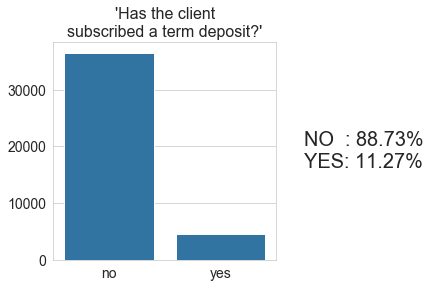

In [7]:
fig, ax = plt.subplots(figsize=(4,4))
ax = sns.countplot(x="y", data=data, ax=ax, color=cp[0]);

ax.set_title("'Has the client\nsubscribed a term deposit?'", size=16)
ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(labelsize=14)

ax.text(
    1.75,
    ax.get_ylim()[1]/2, 
    f'NO  : {(1-(data["y_numeric"]).mean())*100:.2f}%\nYES: {((data["y_numeric"]).mean())*100:.2f}%',
    fontsize=20,
    va='center'
);


We're dealing with considerably unbalanced data. It will be necessary to pay close attention to this, as a simple metrics of accuracy may not be enought to consider our model performant.

# Categorical Data

Let's examine the categorical features in the data set:

In [6]:
data_cat = data.select_dtypes(include='object')
data_cat['y_numeric'] = data['y_numeric']

In [7]:
print(f'There are {data_cat.shape[1]-2} categorical features in the data set:')
for cat_feature in data_cat.columns[:-2]:
    print(f'  - {cat_feature:15}(cardinality: {len(data_cat[cat_feature].unique())})')

There are 10 categorical features in the data set:
  - job            (cardinality: 12)
  - marital        (cardinality: 4)
  - education      (cardinality: 8)
  - default        (cardinality: 3)
  - housing        (cardinality: 3)
  - loan           (cardinality: 3)
  - contact        (cardinality: 2)
  - month          (cardinality: 10)
  - day_of_week    (cardinality: 5)
  - poutcome       (cardinality: 3)


It seems no class has an excessive cardinality, so no additional grouping should be required. We'll have a closer look at them now.

In [8]:
def plot_cat_prevalence(data_cat, cat_feature, **kwargs):
    
    # data manipulation
    d = data_cat.groupby(cat_feature).agg({'y_numeric': [np.mean, 'count']})
    d.columns = ["yes", "freq"]
    d['freq'] = d['freq']/d['freq'].sum()
    d.sort_values(by='freq', inplace=True)
    d *= 100

    #plotting
    ax = d.plot.barh(figsize=kwargs.get('figsize', (5,7)))
    if kwargs.get('xlim100', False):
        ax.set_xlim(0,100)
    
    # text
    ax.set_title(f'Category Prevalence: {cat_feature}', size=kwargs.get('title_size', 16))
    ax.set_xlabel("%", size=kwargs.get('xlabel_size', 14))
    ax.set_ylabel("")
    ax.tick_params(labelsize=12)
    
    # aditional info
    if kwargs.get('target_line', True):
        ax.axvline((data["y_numeric"]).mean()*100, color='r', linestyle='--', label='%yes average')
    if kwargs.get('legend', True):
        ax.legend(loc=kwargs.get('legend_loc', (1.1,0)), fontsize=kwargs.get('legend_loc_size', 12))
    
    return ax

In [10]:
data_cat.groupby('job').agg({'y_numeric': [np.mean, 'count']})

y_numeric       
                   mean  count
job                           
admin.         0.129726  10422
blue-collar    0.068943   9254
entrepreneur   0.085165   1456
housemaid      0.100000   1060
management     0.112175   2924
retired        0.252326   1720
self-employed  0.104856   1421
services       0.081381   3969
student        0.314286    875
technician     0.108260   6743
unemployed     0.142012   1014
unknown        0.112121    330

In [12]:
data_cat.loc[data_cat['job']=='student', 'y_numeric'].mean()

0.3142857142857143

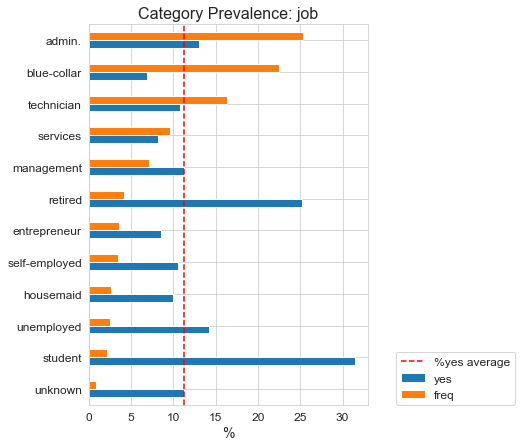

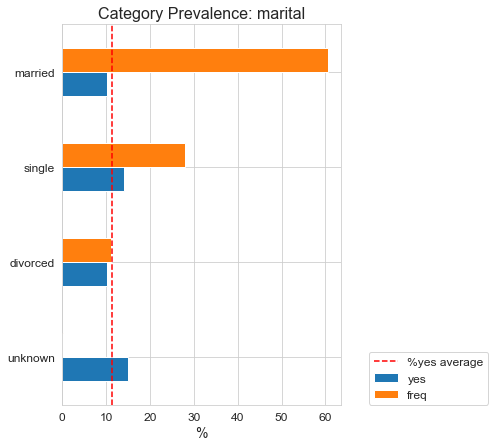

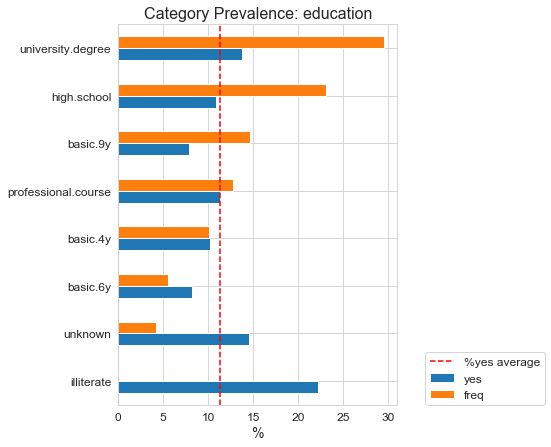

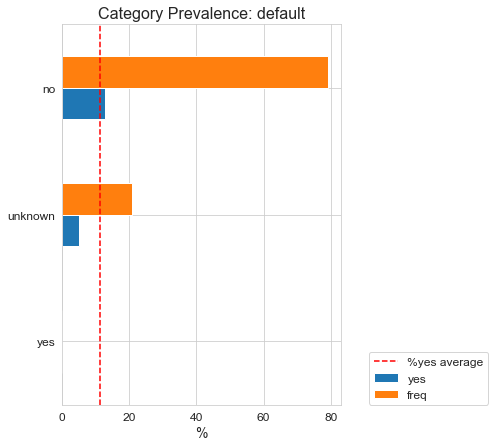

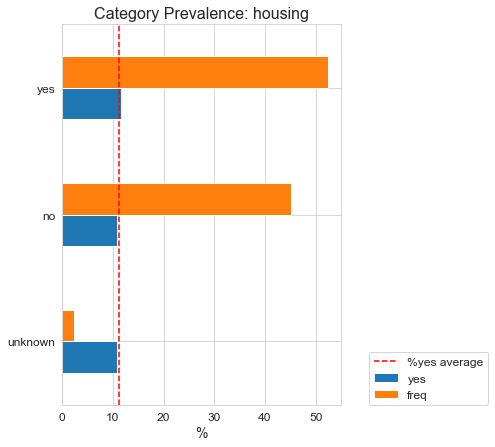

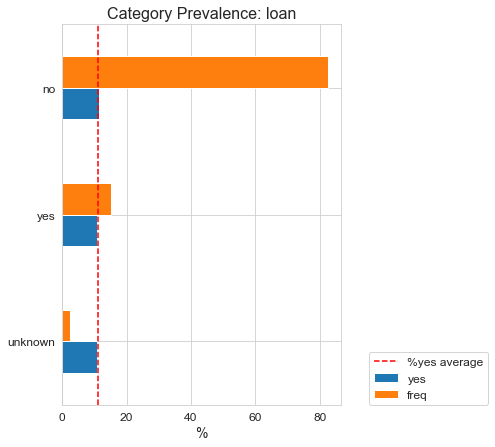

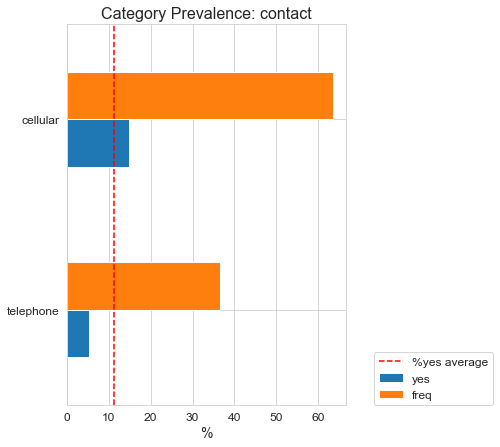

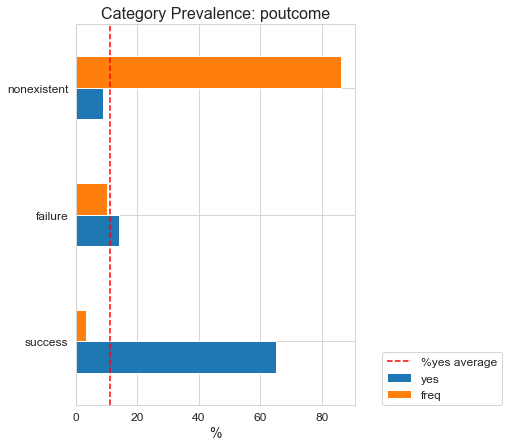

In [9]:
for cat_feature in data_cat.columns[:-2]:
    if cat_feature not in ('month', 'day_of_week'): # temporal data requires different approach
        plot_cat_prevalence(data_cat, cat_feature)

# Numeric Data

In [194]:
data_num = data.select_dtypes(include = ['float64', 'int64'])

First, a general look into the distribution of each of the numerical features:

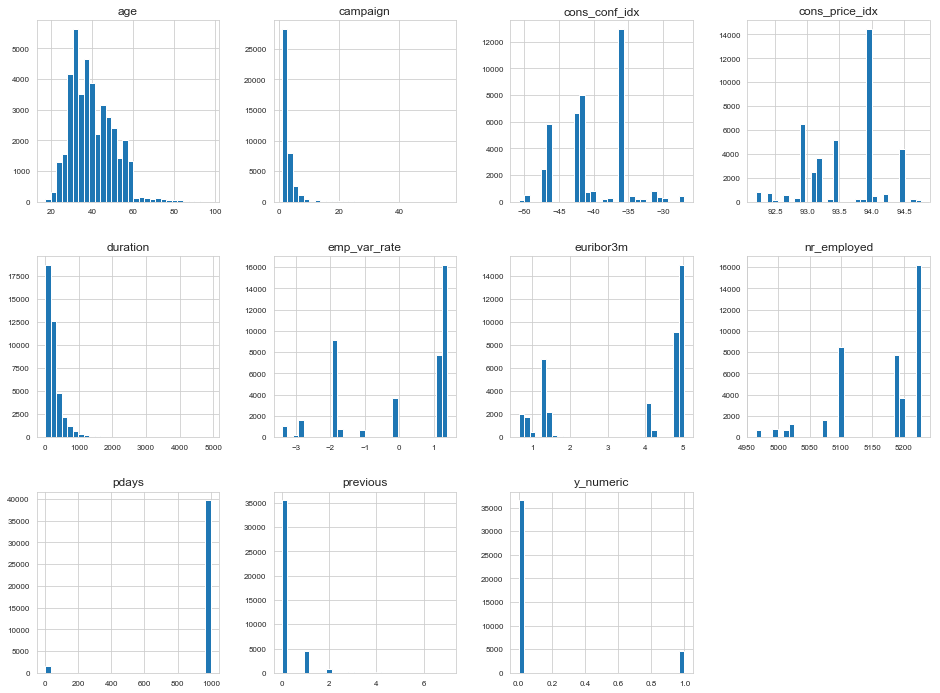

In [205]:
data_num.hist(bins=30, xlabelsize=8, ylabelsize=8, figsize=(16, 12), layout=(3,4));

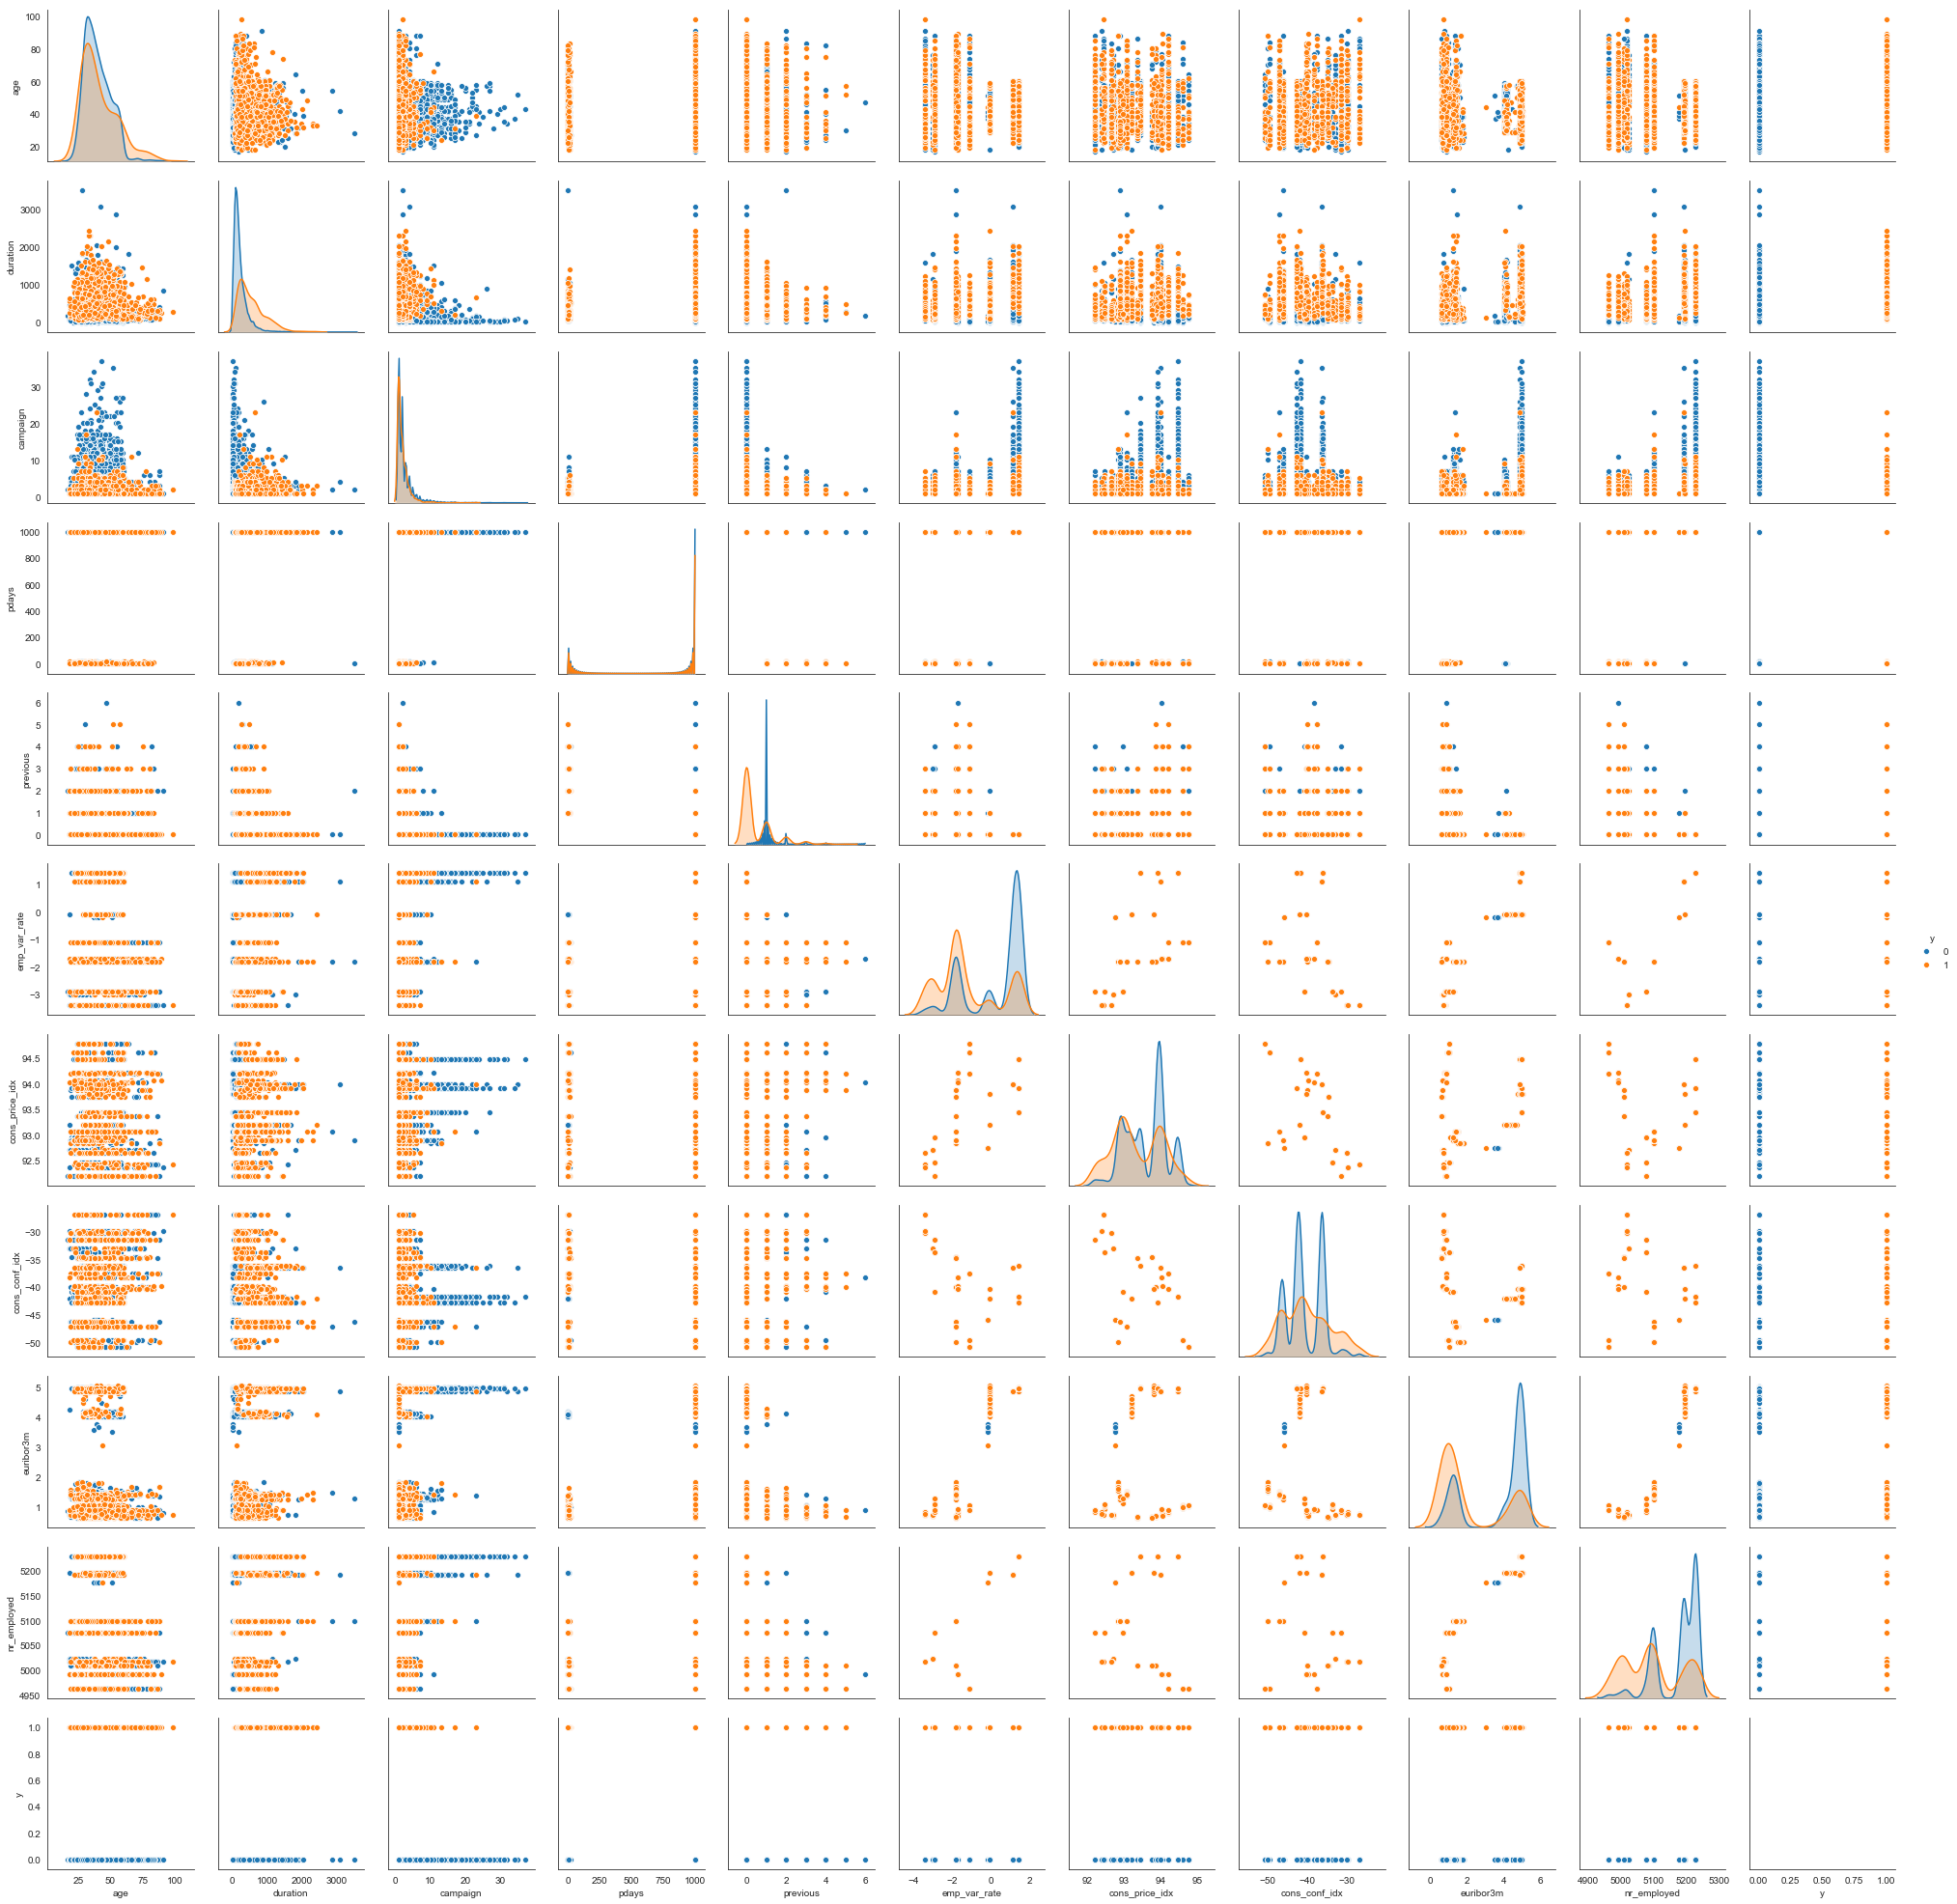

In [43]:
ax = sns.pairplot(data=data_num.sample(frac=0.2), hue='y')

In [11]:
import pandas_profiling

In [13]:
pandas_profiling.ProfileReport(data)

Number of variables,22
Number of observations,41188
Total Missing (%),0.0%
Total size in memory,6.9 MiB
Average record size in memory,176.0 B
Numeric,8
Categorical,11
Boolean,1
Date,0
Text (Unique),0
Rejected,2
